In [1]:
import os, re
import pickle
import numpy as np
import pandas as pd

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import matplotlib.colors as mc
from mpl_toolkits.axes_grid1 import make_axes_locatable

#scipy
from scipy import ndimage
from scipy.stats import gaussian_kde

import rioxarray
import xarray
import rasterio
import xarray as xr

## GDAL
from osgeo import gdal, osr, ogr
 
## WQ_SAT
from wq_sat import config
from wq_sat.satellites import sentinel2
from wq_sat.bathymetry import SDB
from wq_sat.utils import geo_utils, plot_utils, data_utils

In [10]:
region = 'CalaMillor'
year = '2020'
save_plots = True
main_path = os.path.join(config.data_path(), 'bathymetries', region, 'InSitu')

## In-situ bathymetry

{'N': 39.603706288152, 'W': 3.3843306531157413, 'S': 39.58664616930425, 'E': 3.393436068278689}


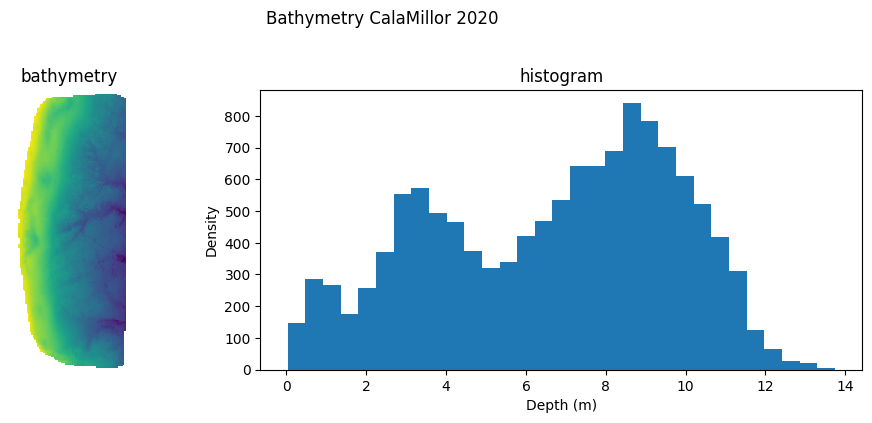

In [11]:
## In-situ bathymetry
file = '{}_Insitu_bathymetry_EPSG32631_{}.tif'.format(region, year)
bathymetry, BBox, crs = geo_utils.load_geotiff(os.path.join(main_path, file))
mx = np.ma.masked_invalid(bathymetry)

## transform coordinates
new_ul = geo_utils.transform_coordinates(BBox[0], inputEPSG=crs, outputEPSG=4326)
new_lr = geo_utils.transform_coordinates(BBox[1], inputEPSG=crs, outputEPSG=4326)

# ROI
roi_coord = {'N': new_ul[0], 'W': new_ul[1], 'S': new_lr[0], 'E': new_lr[1]}
print(roi_coord)

# plot it
fig=plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid((2,3),(0,0))
ax1.imshow(bathymetry)
ax1.set_title('bathymetry')
ax1.axis('off')

ax2 = plt.subplot2grid((2,3),(0,1), colspan=3)
ax2.hist((-bathymetry).flatten(), bins='auto')
ax2.set_title('histogram')
ax2.set_xlabel('Depth (m)')
ax2.set_ylabel('Density')

fig.suptitle('Bathymetry {} {}'.format(region, year))
plt.show()

## Composite Approach

In [12]:
tiles = config.get_tiles(region, year)
Zgr_max, Zr_max, Rs492, Rs559, Rs704, chl, coord = SDB.composite_approach(tiles, roi_coord)

Zgr_max[mx.mask] = np.nan
Zr_max[mx.mask] = np.nan
Rs492[mx.mask] = np.nan
Rs559[mx.mask] = np.nan
Rs704[mx.mask] = np.nan
chl[mx.mask] = np.nan

Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20200924T104031_N0209_R008_T31SED_20200924T143955
Selected pixel region: xmin=3301, ymin=1619, xmax=3380, ymax=1808:
Image size: width=80 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20200924T104031_N0209_R008_T31SED_20200924T143955
Selected pixel region: xmin=3301, ymin=1619, xmax=3380, ymax=1808:
Image size: width=80 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20201006T102819_N0209_R108_T31SED_20201006T124559
Selected pixel region: xmin=3301, ymin=1619, xmax=3380, ymax=1808:
Image size: width=80 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20200919T103649_N0209_R008_T31SED_20200919T125309
Selected pixel region: xmin=3301, ymin=1619, xmax=3380, ymax=1808:
Image size: width=80 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20200916T102649_N0209_R108_T31SED_20200916T124334
Selected pixel region: xmin=3301, ymin=1619, xmax=3380, ymax=1808:
Imag

/home/wq_sat/wq_sat/bathymetry/SDB.py:91: RuntimeWarning: All-NaN slice encountered
  Zgr_max = np.nanmax(Zgreen, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:95: RuntimeWarning: All-NaN slice encountered
  Zr_max = np.nanmax(Zred, axis=2)


In [15]:
Zgr_max.shape

(190, 80)

Text(0.5, 1.0, 'Zred_max')

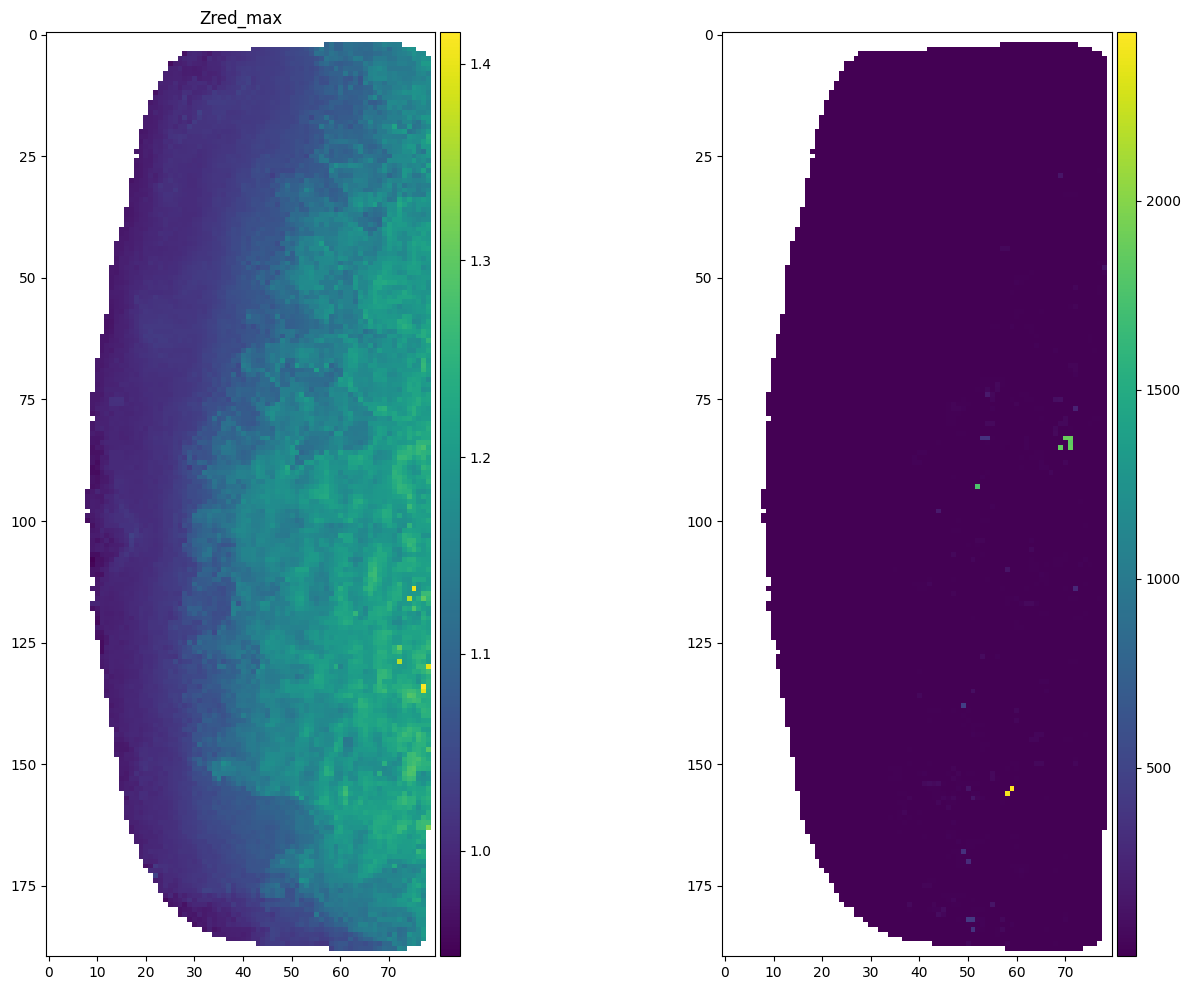

In [16]:
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(Zgr_max, interpolation='nearest', cmap='viridis')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('Zgr_max')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(Zr_max, interpolation='nearest', cmap='viridis')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');
ax1.set_title('Zred_max')

## Calibration

Text(0.5, 1.0, 'pSDB Red vs Prof')

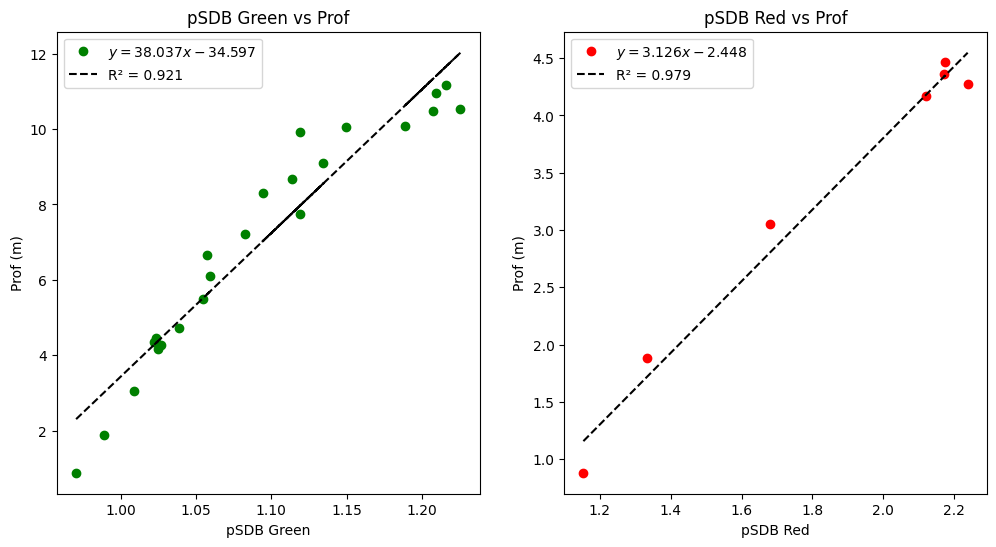

In [18]:
n = 60
m = np.arange(0, bathymetry.shape[1], 3)

Zgr_val = Zgr_max[n, m]
Zr_val = Zr_max[n, m]
bath_val = -bathymetry[n, m]

mx = np.ma.masked_invalid(Zgr_val)
Zgr_val = Zgr_val[~mx.mask]
bath_val_green = bath_val[~mx.mask]

## linear regresion
#Zgreen
coef_gr = np.polyfit(Zgr_val, bath_val_green, 1)
poly_gr = np.poly1d(coef_gr)

# R square
corr_matrix = np.corrcoef(bath_val_green, poly_gr(Zgr_val))
corr = corr_matrix[0,1]
R_Zgr = corr**2

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(Zgr_val, bath_val_green, 'go', label=f'$y = {coef_gr[0]:.3f}x {coef_gr[1]:+.3f}$')
axs[0].plot(Zgr_val, poly_gr(Zgr_val), '--k', label=f'R² = {R_Zgr:.3f}')
axs[0].set_xlabel("pSDB Green")
axs[0].set_ylabel("Prof (m)")
axs[0].legend()
axs[0].set_title("pSDB Green vs Prof")

mx = np.ma.masked_invalid(Zr_val)
Zr_val = Zr_val[~mx.mask]
bath_val = bath_val[~mx.mask]
bath_val = bath_val[:7]
Zr_val = Zr_val[:7]

#Zred
coef_red = np.polyfit(Zr_val, bath_val, 1)
poly_red = np.poly1d(coef_red)

# R square
corr_matrix = np.corrcoef(bath_val, poly_red(Zr_val))
corr = corr_matrix[0,1]
R_Zr = corr**2

axs[1].plot(Zr_val, bath_val, 'ro', label=f'$y = {coef_red[0]:.3f}x {coef_red[1]:+.3f}$')
axs[1].plot(Zr_val, poly_red(Zr_val), '--k', label=f'R² = {R_Zr:.3f}')
axs[1].set_xlabel("pSDB Red")
axs[1].set_ylabel("Prof (m)")
axs[1].legend()
axs[1].set_title("pSDB Red vs Prof")

# Save the full figure...
# if save_plots:
#     fig.savefig(os.path.join(main_path, 'plots', '{}_pSDBGreen_pSDBRed_adjust_{}.png'.format(region, year)))

In [19]:
poly_gr

poly1d([ 38.03683075, -34.59720152])

In [21]:
# save the Zgreen model to disk
Zgr_file = '{}_Zgreen_model_{}.sav'.format(region, year)
pickle.dump(poly_gr, open(os.path.join(main_path, Zgr_file), 'wb'))

# save the Zred model to disk
Zr_file = '{}_Zred_model_{}.sav'.format(region, year)
pickle.dump(poly_red, open(os.path.join(main_path, Zr_file), 'wb'))

## SDBgreen

/tmp/ipykernel_141270/2578684135.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,18], [0,18], 'k-', c='r', alpha=0.75, zorder=0)


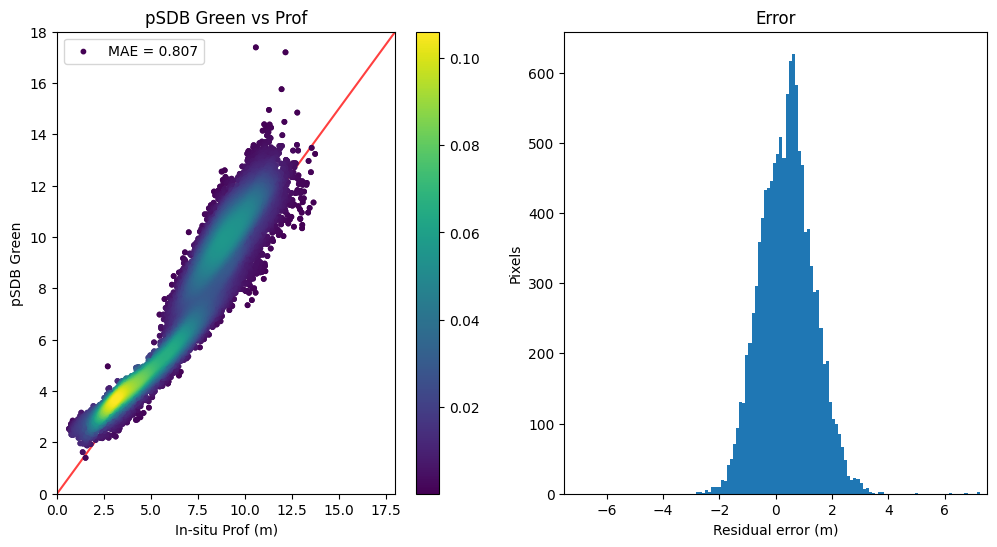

FileNotFoundError: [Errno 2] No such file or directory: '/home/wqsat_data/bathymetries/CalaMillor/InSitu/plots/CalaMillor_Zgreen_adjust_residual_2020.png'

In [22]:
pSDBgreen = poly_gr(Zgr_max)
pSDBgr_diff = pSDBgreen - (-bathymetry)

mx = np.ma.masked_invalid(pSDBgr_diff)
diff = pSDBgr_diff[~mx.mask]

# Calculate the point density
x = -bathymetry[~mx.mask]
y = pSDBgreen[~mx.mask]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.nanmean(np.abs(diff))
RMSE = np.sqrt(np.nanmean(diff**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10)
plt.colorbar(ax_)
axs[0].plot([0,18], [0,18], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
axs[0].set_xlim(0,18)
axs[0].set_ylabel("pSDB Green")
axs[0].set_ylim(0,18)
axs[0].legend()
axs[0].set_title("pSDB Green vs Prof")

axs[1].hist(pSDBgr_diff.flatten(), bins=100)
axs[1].set_xlim(-7.5,7.5)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")
plt.show()

# Save the full figure...
# if save_plots:
#     fig.savefig(os.path.join(main_path, 'plots', '{}_Zgreen_adjust_residual_{}.png'.format(region, year)))

## SDBred

/tmp/ipykernel_141270/1797462837.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,20], [0,20], 'k-', c='r', alpha=0.75, zorder=0)


Text(0.5, 1.0, 'Error')

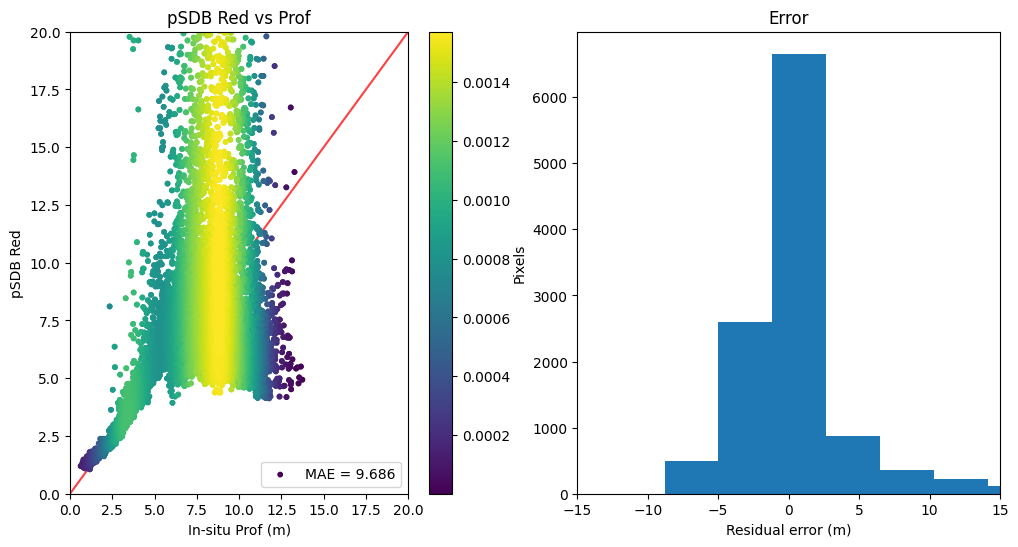

In [23]:
pSDBred = poly_red(Zr_max)
pSDBred_diff = pSDBred - (-bathymetry)

mx = np.ma.masked_invalid(pSDBred_diff)
diffred = pSDBred_diff[~mx.mask]

# Calculate the point density
x = -bathymetry[~mx.mask]
y = pSDBred[~mx.mask]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.mean(np.abs(diffred))
RMSE = np.sqrt(np.nanmean(diffred**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10)
plt.colorbar(ax_)
axs[0].plot([0,20], [0,20], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
axs[0].set_xlim(-0,20)
axs[0].set_ylabel("pSDB Red")
axs[0].set_ylim(-0,20)
axs[0].legend()
axs[0].set_title("pSDB Red vs Prof")

axs[1].hist(pSDBred_diff.flatten(), bins=2000)
axs[1].set_xlim(-15,15)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")

# Save the full figure...
# if save_plots:
#     fig.savefig(os.path.join(main_path, 'plots', '{}_Zred_adjust_residual_{}.png'.format(region, year)))

## Switching model

In [24]:
Switching_SDB = SDB.switching_model(pSDBgreen, pSDBred)

/tmp/ipykernel_141270/1790892700.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,20], [0,20], 'k-', c='r', alpha=0.75, zorder=0)


FileNotFoundError: [Errno 2] No such file or directory: '/home/wqsat_data/bathymetries/CalaMillor/InSitu/plots/CalaMillor_Switching_adjust_residual_2020.png'

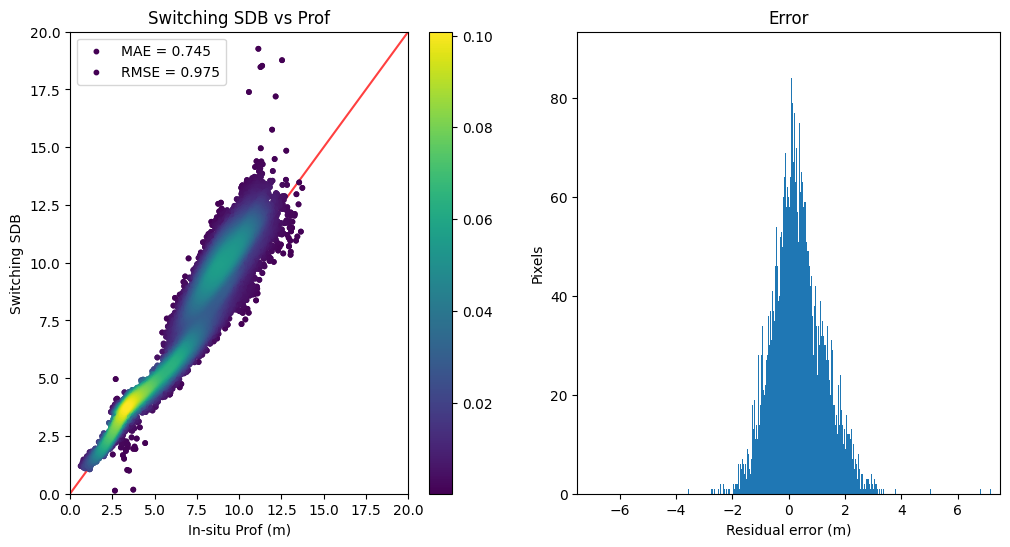

In [25]:
SDB_diff = Switching_SDB - (-bathymetry)

mx = np.ma.masked_invalid(SDB_diff)
diff = SDB_diff[~mx.mask]

# Calculate the point density
x = -bathymetry[~mx.mask]
y = Switching_SDB[~mx.mask]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.mean(np.abs(diff))
RMSE = np.sqrt(np.nanmean(diff**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10, label=f'RMSE = {RMSE:.3f}')
plt.colorbar(ax_)
axs[0].plot([0,20], [0,20], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
axs[0].set_xlim(-0,20)
axs[0].set_ylabel("Switching SDB")
axs[0].set_ylim(-0,20)
axs[0].legend()
axs[0].set_title("Switching SDB vs Prof")

axs[1].hist(SDB_diff.flatten(), bins=1000)
axs[1].set_xlim(-7.5,7.5)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")

# Save the full figure...
if save_plots:
    fig.savefig(os.path.join(main_path, 'plots', '{}_Switching_adjust_residual_{}.png'.format(region, year)))

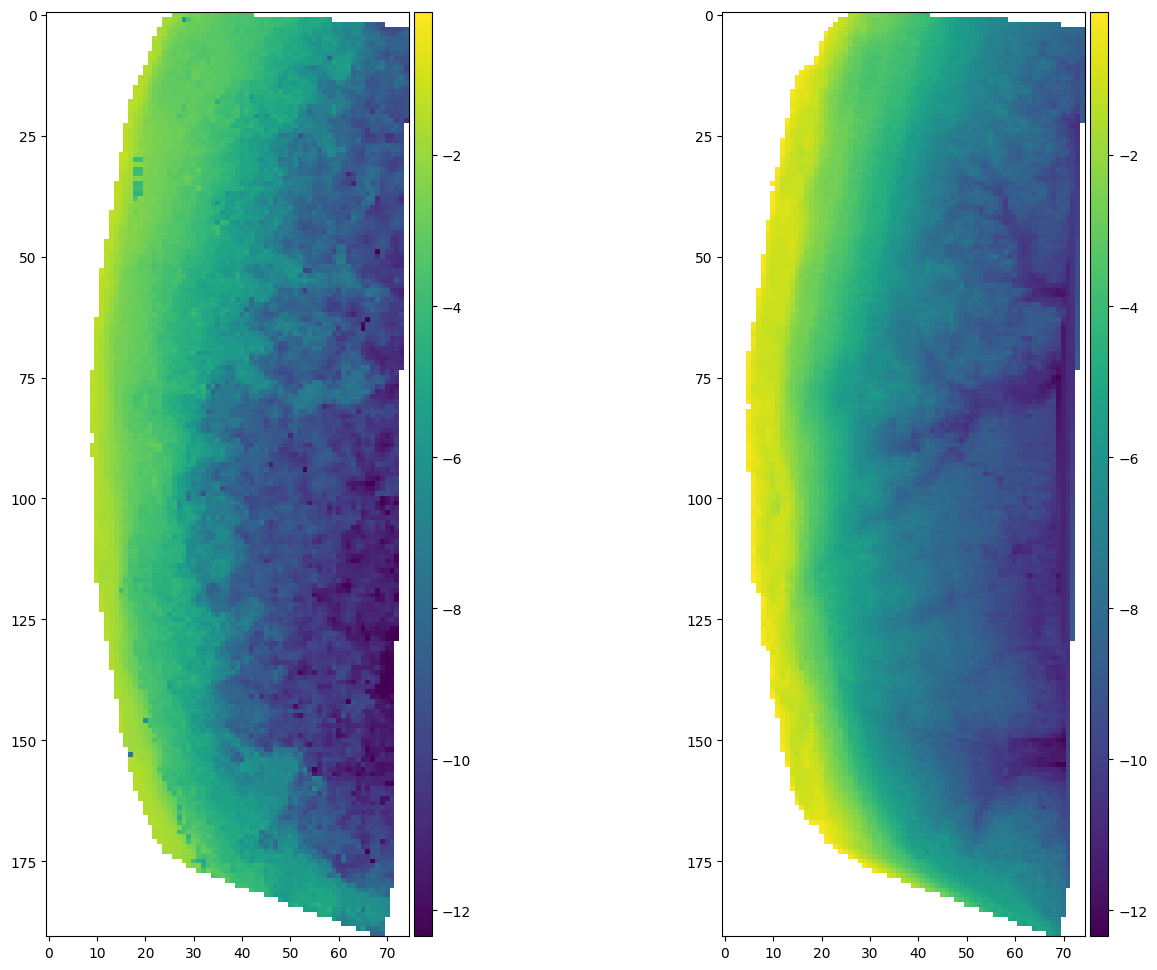

In [12]:
fig = plt.figure(figsize=(16, 12))

sdb_min = np.nanmin(bathymetry)
sdb_max = np.nanmax(bathymetry)

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-Switching_SDB, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(bathymetry, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

In [13]:
# SDB geotiff
file = '{}_Switching_SDB_{}.tif'.format(region, year)
geo_utils.save_gdal(os.path.join(main_path, file), 
                     np.expand_dims(Switching_SDB, axis=-1), 
                     ['Switching_SDB'], 
                     coord['geotransform'], 
                     coord['geoprojection'])

## ODW

In [26]:
ODW_SDB = SDB.odw_model(Switching_SDB, Rs492, Rs559, Rs704)

/tmp/ipykernel_141270/3295877913.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,18], [0,18], 'k-', c='r', alpha=0.75, zorder=0)


FileNotFoundError: [Errno 2] No such file or directory: '/home/wqsat_data/bathymetries/CalaMillor/InSitu/plots/CalaMillor_ODW_adjust_residual_2020.png'

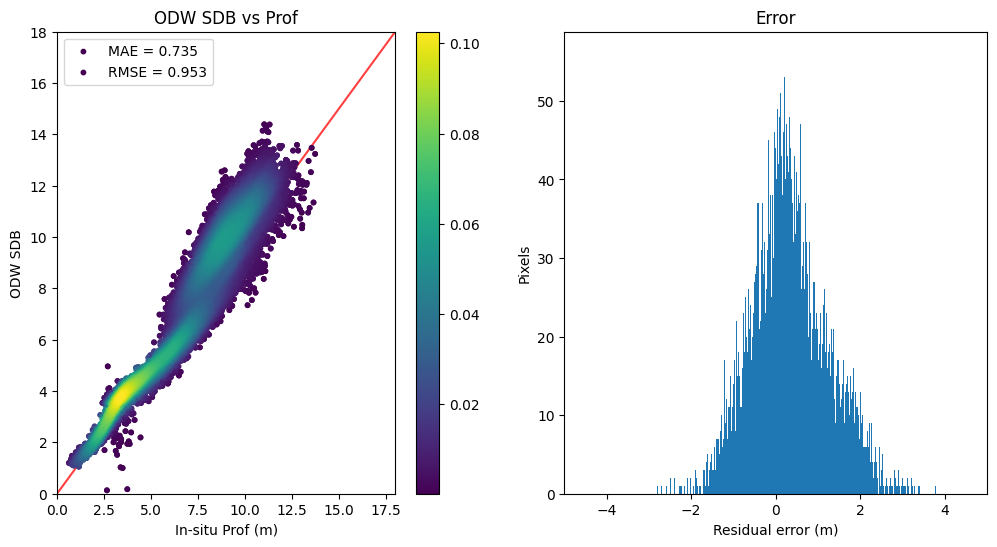

In [27]:
SDB_diff = ODW_SDB - (-bathymetry)

mx = np.ma.masked_invalid(SDB_diff)
diff = SDB_diff[~mx.mask]

# Calculate the point density
x = -bathymetry[~mx.mask]
y = ODW_SDB[~mx.mask]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.mean(np.abs(diff))
RMSE = np.sqrt(np.nanmean(diff**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10, label=f'RMSE = {RMSE:.3f}')
plt.colorbar(ax_)
axs[0].plot([0,18], [0,18], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
axs[0].set_xlim(0,18)
axs[0].set_ylabel("ODW SDB")
axs[0].set_ylim(0,18)
axs[0].legend()
axs[0].set_title("ODW SDB vs Prof")

axs[1].hist(SDB_diff.flatten(), bins=1000)
axs[1].set_xlim(-5,5)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")

# Save the full figure...
# if save_plots:
#     fig.savefig(os.path.join(main_path, 'plots', '{}_ODW_adjust_residual_{}.png'.format(region, year)))

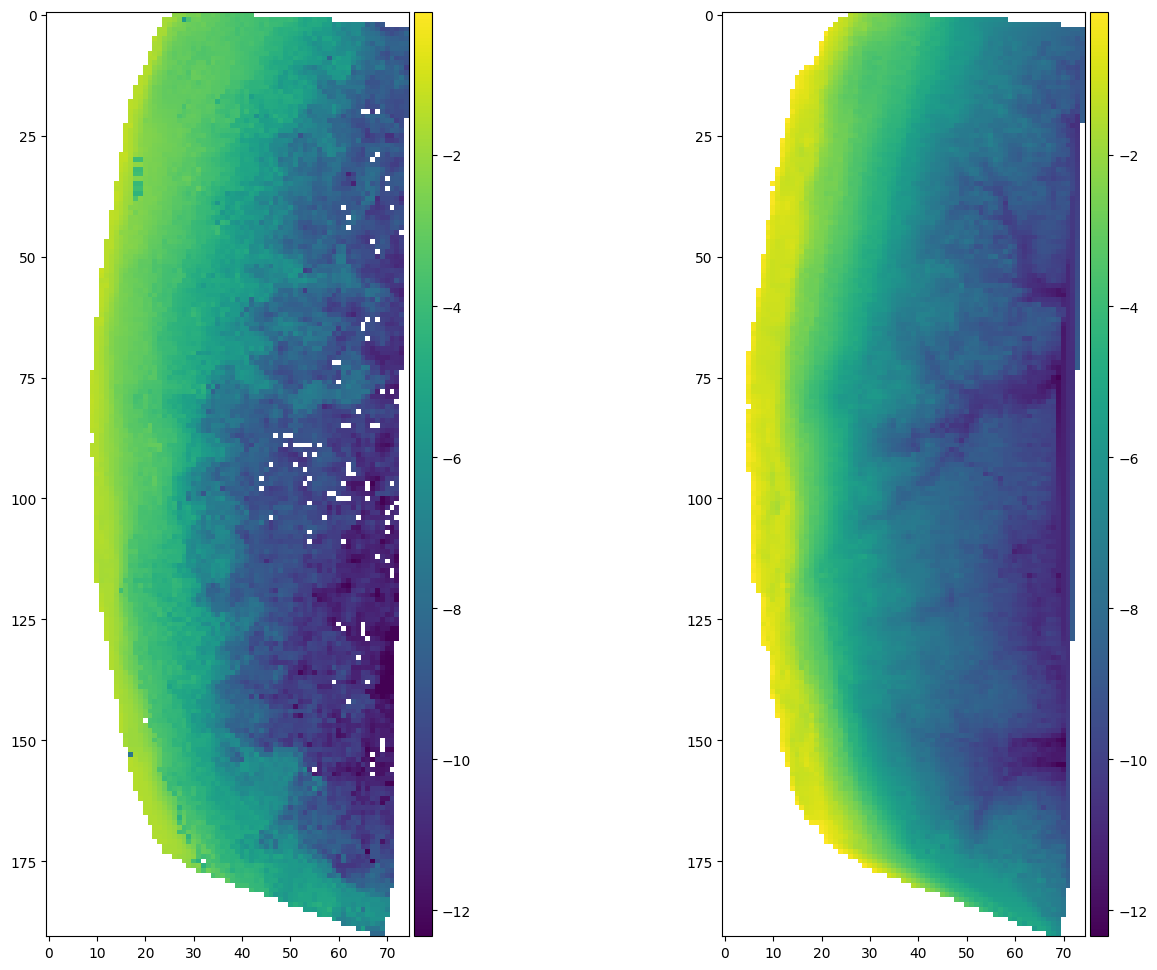

In [16]:
fig = plt.figure(figsize=(16, 12))

sdb_min = np.nanmin(bathymetry)
sdb_max = np.nanmax(bathymetry)

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-ODW_SDB, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(bathymetry, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

## interpolation

In [28]:
ODW_interpolation = data_utils.interpolation2d(ODW_SDB)

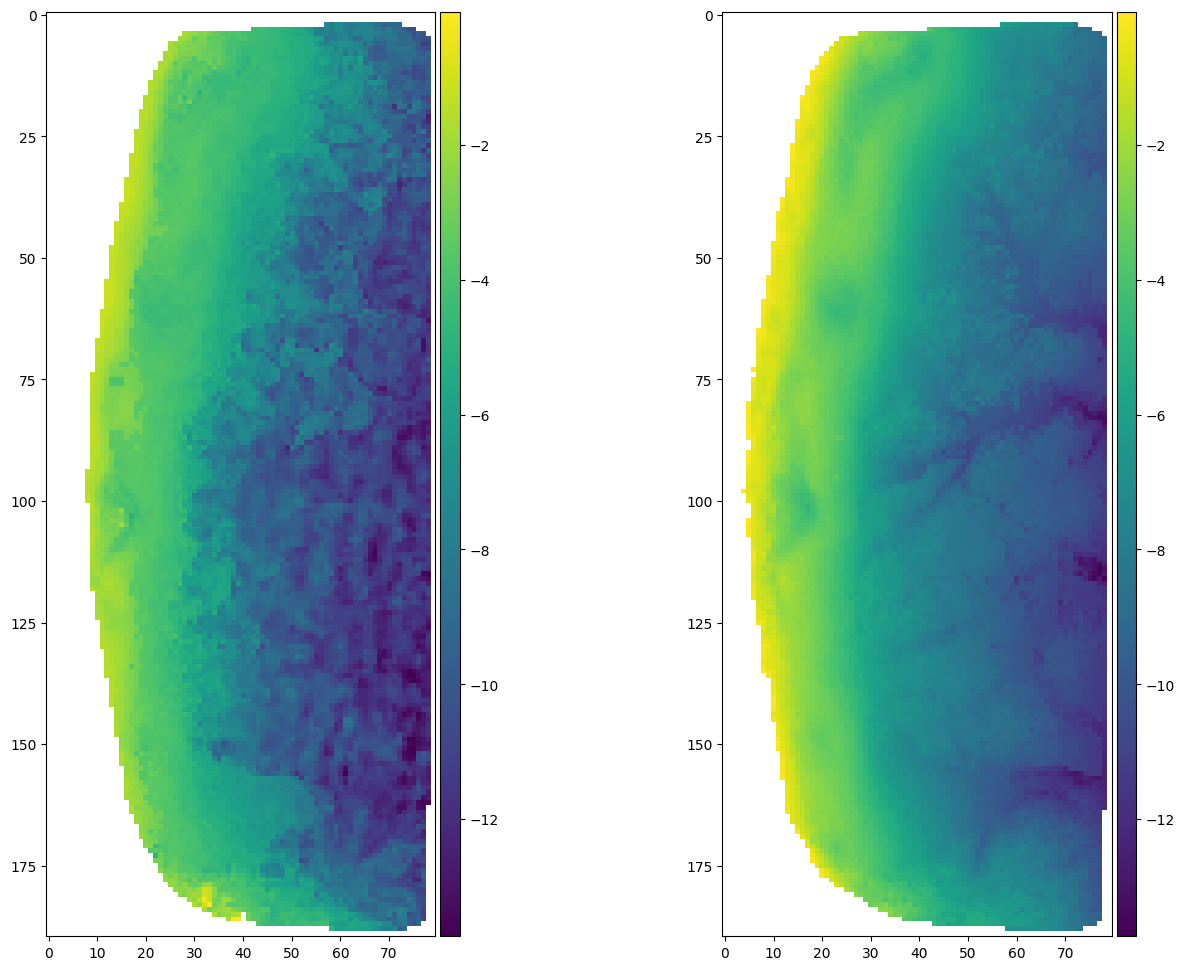

In [29]:
fig = plt.figure(figsize=(16, 12))

sdb_min = np.nanmin(bathymetry)
sdb_max = np.nanmax(bathymetry)

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-ODW_interpolation, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(bathymetry, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

/tmp/ipykernel_141270/529071135.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,18], [0,18], 'k-', c='r', alpha=0.75, zorder=0)


Text(0.5, 1.0, 'Error')

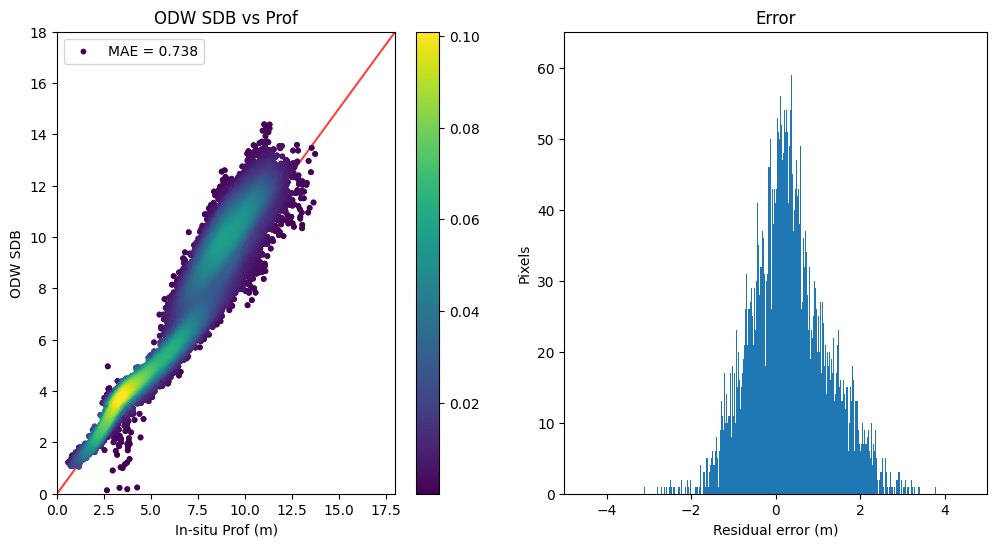

In [30]:
SDB_diff = ODW_interpolation - (-bathymetry)

mx = np.ma.masked_invalid(SDB_diff)
diff = SDB_diff[~mx.mask]

# Calculate the point density
x = -bathymetry[~mx.mask]
y = ODW_interpolation[~mx.mask]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.mean(np.abs(diff))
RMSE = np.sqrt(np.nanmean(diff**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10)
plt.colorbar(ax_)
axs[0].plot([0,18], [0,18], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
axs[0].set_xlim(0,18)
axs[0].set_ylabel("ODW SDB")
axs[0].set_ylim(0,18)
axs[0].legend()
axs[0].set_title("ODW SDB vs Prof")

axs[1].hist(SDB_diff.flatten(), bins=1000)
axs[1].set_xlim(-5,5)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")

# Save the full figure...
# if save_plots:
#     fig.savefig(os.path.join(main_path, 'plots', '{}_ODW_interpolation_adjust_residual_{}.png'.format(region, year)))